# Constructing dense offset maps from Sentinel-1 A/B SLCs using topsApp.py

**Authors**: Bryan Riel, Brent Minchew

In this notebook, we will explore how to configure `topsApp.py` to generate dense offset maps (pixel tracking) from co-registered Sentinel-1 SLCs. The processing setup is identical to normal `topsApp.py` processing in that we download the appropriate SLC data, prepare a DEM for our study area, and download the necessary orbit and aux files from ASF/ESA (see previous tutorials on processing in TOPS mode with `topsApp.py`). For the purposes of creating dense offset maps for this tutorial, we will skip processing steps necessary for InSAR processing, which are mainly focused on precise azimuth co-registration and ionospheric correction for TOPS mode and are not needed for pixel tracking.

## Quick overview on dense offsets

The basic mathematical operation underpinning dense offset creation is 2D cross-correlation, which is a generalization of cross-correlation/discrete convolution in 1D (Wikipedia: https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif)

<img src="support_files/convolution1d_wiki.gif" width=600>

For a given patch of a reference image, we extract a template patch from a secondary image (where the secondary image has been co-registered to the reference image), and we slide the template patch over the reference patch and compute the 2D cross-correlation at each sliding position. This operation creates a 2D "correlation surface", and the coordinate of the peak of that surface tells us the nominal displacement (offset) between the two patches. The schematic below illustrates this procedure

![Template matching schematic](support_files/ampcor_schematic.png)

In the above cartoon, we slid the template over the source image at 9 discrete locations (3x3 search), and the peak correlation is at index (1, 1). By repeating this procedure for a dense array of patches, we can create a dense offset map, e.g.:

<img src="support_files/ampcor_global.png" width=300 height=600/>

In ISCE and `topsApp.py`, 2D cross-correlation is performed on reference and secondary SLCs. The complex data are converted into magnitude images prior to cross-correlation, and the offset map parameters can be configured in the top-level `topsApp.xml` file. In addition to nominal offsets, ISCE provides estimates of correlation signal-to-noise ratio (SNR) and covariance, where the latter is estimated by computing the curvature of the correlation surface.

### Advantages and disadvantages of dense offset maps

Dense offsets maps are useful in situations where ground or surface displacement is large between two acquisition dates. In these cases, reference and secondary SLCs can not be precisely aligned, and we would get complete decoherence in the interferometric phase. Such situations are common in glaciology, certain geomorphology applications (e.g., landslides), and for very large earthquakes. Additionally, dense offsets automatically give us displacement in two directions (range and azimuth), whereas InSAR will only provide phase changes in the range direction.

Of course, the main disadvantage of offset maps is the much higher level of noise in the cross-correlation measurements as compared to InSAR phase. For example, the figure below compares InSAR phase and range pixel offsets for the recent M7.0 Haiti earthquake (obtained from Eric Fielding Twitter https://twitter.com/EricFielding/status/1428629519947034624):

<img src="support_files/HaitiOffsets.png" width=900/>

Note, this comparison is only valid if the InSAR phase is not decorrelated. In general, offsets will provide a more robust, albeit noisier, estimate of surface displacment. Another disadvantage is that dense offset map generation takes considerably more compute power as compared to interferogram formation, but ISCE does provide GPU implementations of dense offsets to significantly reduce computation time.

 ## Study area and setup

In this tutorial, our study area is Pine Island Glacier (PIG) in West Antartica. PIG is a fast-flowing ice stream and is responsible for about 25% of the mass loss from Antarctica for the past few decades. Here, we will use Sentinel-1 A/B IW SLCs for path 65, frame 906 (ascending) for four dates: 2020-01-12, 2020-01-18, 2020-01-24, and 2020-01-30. From these four dates, we will generate three separate maps of dense range and azimuth offsets.

<img src="support_files/google_earth_preview.png" width=600 height=600/>

From the preview image, we can see that the fast flowing parts of PIG and its ice shelf are imaged in the top two swaths (2 and 3), which will allow us to cut down on processing time with `topsApp.py`.

For the digital elevation model (DEM), we will use the Reference Elevation Model of Antarctica (REMA) 100 meter mosaic, which can be accessed here (https://www.pgc.umn.edu/data/rema/). We extract two subsets: i) a larger subset for TOPS processing, and ii) a smaller subset for geocoding the dense offsets. For both subsets, we warp the REMA data from Polar Stereographic South to WGS84 and apply a geoid correction. Finally, for some of the plots below, we will use the Landsat Image Mosaic of Antartica (LIMA: https://lima.usgs.gov/) as a background image.

## TOPS processing

We will be using `topsApp.py` to process each pair individually. A much better approach is to process all images in a "stack" where all images will be processed to a common radar geometry, which removes redundant geometry processing steps. We will go over this strategy using ISCE stack tools in a later tutorial.
<br>
<div class="alert alert-danger">
<b>Important Note:</b> 
The code below is meant to demonstrate working environments and configuration for TOPS pairs. The data have not been uploaded to Open SAR Lab, so the code cells will not run properly.
</div>

Let's first import necessary Python packages. Note that most of the interaction with `topsApp.py` demonstrated below will be from the shell.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import datetime
import glob
import sys
import os
from osgeo import gdal
import cv2 as cv
import scipy.ndimage as ndimage
import isce

# Some utility functions for plotting and loading data
from utilities import *

# Set environment variables for ISCE
isce_path = os.path.join(isce.__path__[0].strip(), 'applications')
os.environ['OMP_NUM_THREADS'] = '16'
os.environ['PATH'] = '%s:%s' % (isce_path, os.environ['PATH'])
plt.rc('font', size=13)
parent_dir = os.getcwd()

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce


Let's explore our top-level directory structure. Here, the S1A/B SLC zip files have been downloaded into the `vertex` directory, and the orbit and auxiliary data have been downloaded into the `orbit` and `aux` directories, respectively. We have created two separate processing directories for two date pairs: `20200118_20200112` and `20200124_20200118`. In general, when processing three or more SLCs, it is more efficient to use "stack" processing (see `topsStack`), but to simplify this tutorial, we will process the two date pairs independently with `topsApp.py`. Finally, within each processing directory, we have prepared the DEM subsets and initialized the XML configuration files.

In [2]:
!ls -l --color

total 4544
drwxr-xr-x. 10 briel mitusers    4096 Aug 24 03:16 20200118_20200112
drwxr-xr-x. 10 briel mitusers    4096 Aug 24 03:16 20200124_20200118
drwxr-xr-x. 10 briel mitusers    4096 Aug 24 03:15 20200130_20200124
drwxrwxrwx.  8 briel mitusers    4096 Aug 19 20:22 aux
-rwxr-xr-x.  1 briel mitusers 4614344 Aug 25 04:00 nb_topsApp_offsets.ipynb
drwxrwxrwx.  2 briel mitusers    4096 Aug 23 21:47 orbit
drwxr-xr-x.  2 briel mitusers      46 Aug 24 04:38 __pycache__
drwxr-xr-x.  2 briel mitusers    4096 Aug 25 03:31 support_files
-rw-r--r--.  1 briel mitusers    6458 Aug 24 04:38 utilities.py
drwxr-xr-x.  2 briel mitusers    4096 Aug 23 21:48 vertex


In [3]:
!ls vertex

S1A_IW_SLC__1SSH_20200112T043556_20200112T043623_030762_038717_3E04.zip
S1A_IW_SLC__1SSH_20200124T043556_20200124T043623_030937_038D3B_0851.zip
S1B_IW_SLC__1SSH_20200118T043514_20200118T043541_019866_025927_DD28.zip
S1B_IW_SLC__1SSH_20200130T043514_20200130T043541_020041_025EBC_928F.zip


In [4]:
!ls -l orbit
print('')
!ls -l aux

total 21540
-rwxr-xr-x. 1 briel mitusers 4409896 Aug 19 20:19 S1A_OPER_AUX_POEORB_OPOD_20200201T120657_V20200111T225942_20200113T005942.EOF
-rwxr-xr-x. 1 briel mitusers 4409584 Aug 19 20:19 S1A_OPER_AUX_POEORB_OPOD_20200207T120708_V20200117T225942_20200119T005942.EOF
-rwxr-xr-x. 1 briel mitusers 4409896 Aug 19 20:19 S1A_OPER_AUX_POEORB_OPOD_20200213T120800_V20200123T225942_20200125T005942.EOF
-rwxr-xr-x. 1 briel mitusers 4409856 Aug 19 20:19 S1B_OPER_AUX_POEORB_OPOD_20200207T110539_V20200117T225942_20200119T005942.EOF
-rwxr-xr-x. 1 briel mitusers 4410509 Aug 23 21:47 S1B_OPER_AUX_POEORB_OPOD_20200219T110951_V20200129T225942_20200131T005942.EOF

total 0
drwxrwxrwx. 4 briel mitusers 136 Aug 19 20:19 S1A_AUX_CAL_V20190228T092500_G20210104T141310.SAFE
drwxrwxrwx. 4 briel mitusers 136 Aug 19 20:19 S1A_AUX_INS_V20190228T092500_G20190227T100643.SAFE
drwxrwxrwx. 4 briel mitusers 136 Aug 19 20:19 S1A_AUX_PP1_V20190228T092500_G20210104T141253.SAFE
drwxrwxrwx. 4 briel mitusers 136 Aug 19 20:19 S1

### Configuring the topsApp.xml file

Below is an example of how we have configured the `topsApp.xml` file to skip unnecessary InSAR processing steps and perform dense offsets. Note that in IW mode, the SLC pixel spacing is roughly 2.3 meters in range and 14.1 meters in azimuth, which is why we have prescribed a rectangular window for dense offsets in order to get roughly square pixels in the output offset fields.
```xml
<?xml version="1.0" encoding="UTF-8"?>
<topsApp>
  <component name="topsinsar">
    <property name="Sensor name">SENTINEL1</property>

    <!-- Scene XML files -->
    <component name="reference">
      <catalog>20200124.xml</catalog>
    </component>
    <component name="secondary">
      <catalog>20200118.xml</catalog>
    </component>

    <!-- The swaths to process -->
    <property name="swaths">[2,3]</property>

    <!-- DEM for processing -->
    <property name="demFilename">pig_rema_100m_filled_wgs84.dem</property>
    <!-- DEM for geocoding -->
    <property name="geocode demfilename">pig_rema_100m_filled_wgs84_crop.dem</property>

    <!-- Unset all InSAR processing steps -->
    <property name="do interferogram">False</property>
    <property name="do ESD">False</property>
    <property name="do unwrap">False</property>
    <property name="do unwrap 2 stage">False</property>
    <property name="do ionosphere correction">False</property>
    <property name="geocode list">[]</property>
      
    <!-- Import Note:

    In order to geocode geometry products (lon.rdr, lat.rdr, los.rdr), we need to at
    least generate and merge the burst interferograms in order for topsApp.py to
    properly detect and geocode those products. In this case, set the following:

    <property name="do interferogram">True</property>
    <property name="geocode list">['merged/lon.rdr', 'merged/lat.rdr', 'merged/los.rdr']</property>
    -->

    <!-- Parameters for dense offsets -->
    <property name="do denseoffsets">True</property>
    <property name="Filter window size">3</property>
    <property name="Ampcor window width">256</property>
    <property name="Ampcor window height">64</property>
    <property name="Ampcor search window width">40</property>
    <property name="Ampcor search window height">10</property>
    <property name="Ampcor skip width">128</property>
    <property name="Ampcor skip height">32</property>

  </component>
</topsApp>
```
For the dense offset parameters, see the following diagram to guide your selection. 

<img src="support_files/offset_parameters.png" width=700>

### XML files for specific scenes

The following two XML code blocks demonstrate how we configure the reference and secondary scenes to point to where we have downloaded the SLC zip files, as well as the orbit and aux directories. The reference scene:
```xml
<?xml version="1.0" encoding="UTF-8"?>
<component name="reference">
  <property name="safe">['../vertex/S1A_IW_SLC__1SSH_20200124T043531_20200124T043558_030937_038D3B_FED1.zip']</property>
  <property name="output directory">referencedir</property>
  <property name="orbit directory">../orbit</property>
  <property name="auxiliary data directory">../aux</property>
  <property name="polarization">hh</property>
</component>
```
The secondary scene:
```xml
<?xml version="1.0" encoding="UTF-8"?>
<component name="secondary">
  <property name="safe">['../vertex/S1B_IW_SLC__1SSH_20200118T043449_20200118T043516_019866_025927_EC6E.zip']</property>
  <property name="output directory">secondarydir</property>
  <property name="orbit directory">../orbit</property>
  <property name="auxiliary data directory">../aux</property>
  <property name="polarization">hh</property>
</component>
```

Let's now move to the processing directory for our first date pair and run the TOPS processing.
<br>
<div class="alert alert-danger">
<b>Reminder:</b> 
The actual processing directories and data have not been uploaded to Open SAR Lab, so the shell commands in this notebook will not work properly.
</div>

In [ ]:
os.chdir(os.path.join(parent_dir, '20200118_20200112'))

In [ ]:
# Run initialization steps: unpacking data, aux/orbit data, and verifying DEM
!topsApp.py --start=startup --end=verifyDEM

The next set of steps are focused on refining the coregistration between the reference
and secondary images (i.e., Enhanced Spectral Diversity (ESD)) and performing ionospheric corrections necessary for InSAR processing. With our configuration for dense offsets, half of these steps will be skipped.

In [ ]:
# Run 'topo' step: this maps the DEM into the reference image geometry at burst overlaps.
# This data is used for the co-registration of the secondary image into the reference geometry
!topsApp.py --start=topo --end=geocode > coregister.log

We now have all the intermediate data necessary to co-register the SLC images and perform dense offsets. We will compute the offsets, run a median filter on the offset fields, geocode them to our DEM subset, and warp the geocoded offsets to Polar Stereographic South. But first, let us explore the cross-correlation procedure in detail by extracting a sample patch from the reference and secondary SLCs. Note, in the code below, we extract patches from pre-computed, multi-looked amplitude images.

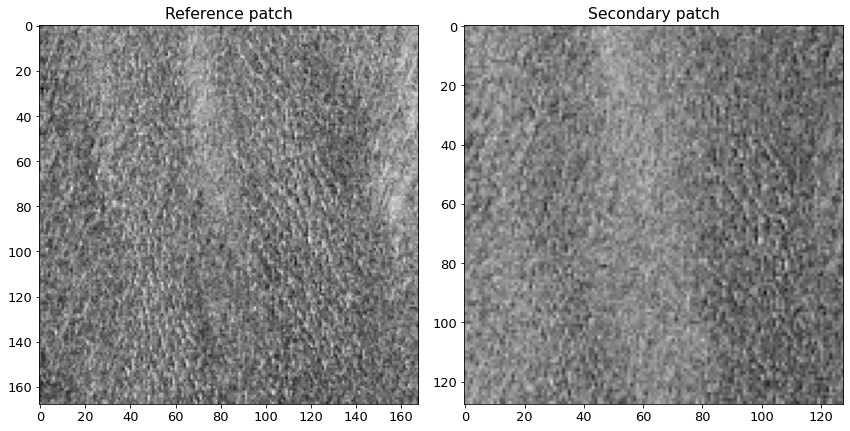

In [8]:
# Load 128x128 secondary (template patch)
sec_patch = np.load(os.path.join(parent_dir, 'support_files', 'sec_patch.npy'))
win_size = sec_patch.shape[0]

# Load 128x128 reference patch, which also includes a 20 pixel buffer for the search window
ref_patch = np.load(os.path.join(parent_dir, 'support_files', 'ref_patch.npy'))
search_win = (ref_patch.shape[0] - win_size) // 2

# Remove mean value from patches
ref_patch -= np.mean(ref_patch)
sec_patch -= np.mean(sec_patch)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
im1 = ax1.imshow(ref_patch, cmap='gray')
im2 = ax2.imshow(sec_patch, cmap='gray')
im2.set_clim(im1.get_clim())
ax1.set_title('Reference patch')
ax2.set_title('Secondary patch')
fig.set_tight_layout(True)

To demonstrate the cross-correlation operation, we will use the match template function implemented in the OpenCV package (https://docs.opencv.org/4.5.2/d4/dc6/tutorial_py_template_matching.html) which outputs a correlation surface between a reference and template patch. This function and the underlying cross-correlation operation implemented in ISCE are quite similar, although ISCE implements additional machinery specifically for SLC images with varying frequency content.

Integer shifts: 0 3


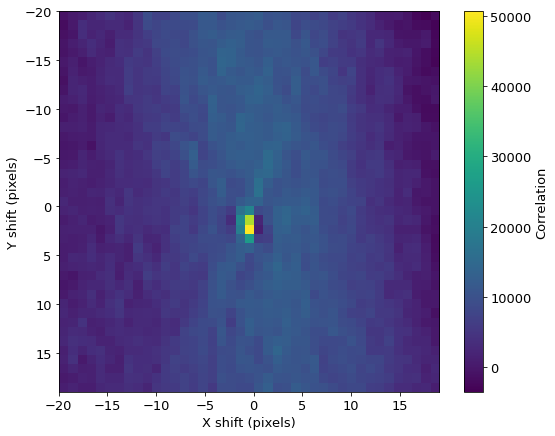

In [9]:
# Call OpenCV template matching to get a correlation surface
correlation = cv.matchTemplate(ref_patch.astype(np.float32),
                               sec_patch.astype(np.float32),
                               cv.TM_CCOEFF)

# Construct arrays corresponding to the offset values
xoff = np.arange(-search_win, search_win, 1)
yoff = np.arange(-search_win, search_win, 1)

# Find the integer offset
indmax = np.argmax(correlation)
row_max, col_max = np.unravel_index(indmax, correlation.shape)

# Get the corresponding shift
max_xoffset = xoff[col_max]
max_yoffset = yoff[row_max]
print('Integer shifts:', max_xoffset, max_yoffset)

fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(correlation, extent=[xoff[0], xoff[-1], yoff[-1], yoff[0]])
cbar = plt.colorbar(im, ax=ax, orientation='vertical')
cbar.set_label('Correlation')
ax.set_xlabel('X shift (pixels)');
ax.set_ylabel('Y shift (pixels)');

From the correlation surface, we can see a fairly concentrated peak at a coordinate of $\Delta X$ = 0 pixels and $\Delta Y$ = 3 pixels, which indicates most of the shift is in the azimuth direction. For most applications, we want to get *sub-pixel* resolution in the offsets. One way to achieve this is oversample the correlation surface. In ISCE, this is done in the frequency domain for computational efficiency, but here, we will use a simple interpolation routine as an example. Note that we extract a small sub-window around the peak correlation value prior to oversampling.

Coarse integer X offset: 0
Coarse integer Y offset: 3
Sub-pixel X offset: -0.1968503937007875
Sub-pixel Y offset: 2.637795275590551


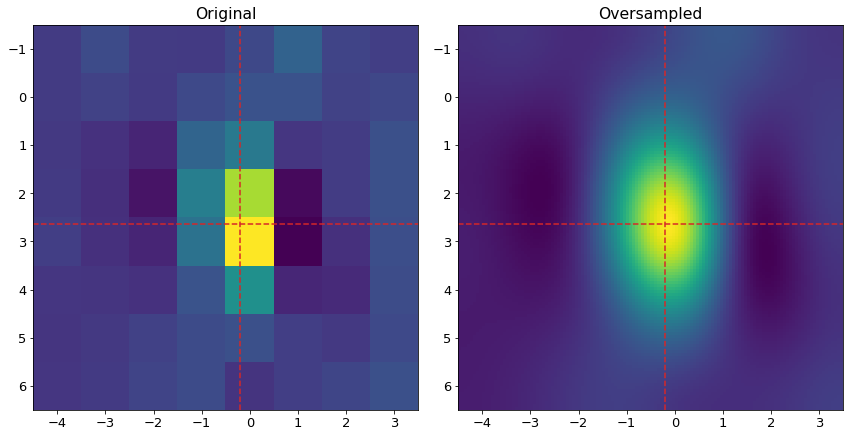

In [10]:
# Index of the peak
peak_index = np.argmax(correlation)
peak_row, peak_col = np.unravel_index(peak_index, correlation.shape)
coarse_dx = peak_col - search_win
coarse_dy = peak_row - search_win
print('Coarse integer X offset:', coarse_dx)
print('Coarse integer Y offset:', coarse_dy)

# Slice a small window
zoom_window = 8
row_slice = slice(peak_row - zoom_window // 2, peak_row + zoom_window // 2)
col_slice = slice(peak_col - zoom_window // 2, peak_col + zoom_window // 2)
correlation_subset = correlation[row_slice, col_slice]

# Call zoom function
zoom_factor = 16
correlation_zoom = ndimage.zoom(correlation_subset, zoom=zoom_factor, prefilter=False, order=4)

# Compute the grid corresponding to the oversampled coordinates CENTERED on peak
# These are the normalized "sub-pixel" coordinates
x = np.linspace(-zoom_window // 2, zoom_window // 2 - 1, zoom_factor * zoom_window)
y = np.linspace(-zoom_window // 2, zoom_window // 2 - 1, zoom_factor * zoom_window) # same as x
X, Y = np.meshgrid(x, y)

# Get index of peak oversampled correlation
peak_zoom_index = np.argmax(correlation_zoom)
peak_zoom_row, peak_zoom_col = np.unravel_index(peak_zoom_index, correlation_zoom.shape)

# Get the sub-pixel offsets
dx = X[peak_zoom_row, peak_zoom_col] + coarse_dx
dy = Y[peak_zoom_row, peak_zoom_col] + coarse_dy
print('Sub-pixel X offset:', dx)
print('Sub-pixel Y offset:', dy)

# Construct the image extent of the sub-window
half_zoom = zoom_window // 2
extent = np.array([-half_zoom + coarse_dx, half_zoom + coarse_dx,
                   half_zoom + coarse_dy, -half_zoom + coarse_dy]) - 0.5

# View the oversampled window next to the original
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

im1 = ax1.imshow(correlation_subset, extent=extent)
im2 = ax2.imshow(correlation_zoom, extent=extent)
# Plot location of sub-pixel peak
for ax in (ax1, ax2):
    ax.axvline(dx, ls='--', color='C3')
    ax.axhline(dy, ls='--', color='C3')

ax1.set_title('Original')
ax2.set_title('Oversampled')
fig.set_tight_layout(True)


After oversampling of the correlation surface by a factor 16, we now estimate $\Delta X$ = -0.20 pixels and $\Delta Y$ = 2.64 pixels. Let's now run dense offsets in `topsApp.py` with the parameters in the `topsApp.xml` file above using the `denseoffsets` step. Additionally, we will perform a median filter with a window size of 3 and geocode the offsets to geocoding DEM `pig_rema_100m_filled_wgs84_crop.dem`.

In [10]:
# Run offsets, filter, and geocode
!topsApp.py --start=denseoffsets --end=geocodeoffsets > ampcor.log

In [24]:
# List the generated offset files in the 'merged' directory
!ls -l merged/*dense_off*

-rw-r--r--. 1 briel mitusers  1077712 Aug 19 22:19 merged/dense_offsets.bil
-rw-r--r--. 1 briel mitusers 18084168 Aug 19 22:19 merged/dense_offsets.bil.geo
-rw-r--r--. 1 briel mitusers      840 Aug 19 22:19 merged/dense_offsets.bil.geo.vrt
-rw-r--r--. 1 briel mitusers     3828 Aug 19 22:19 merged/dense_offsets.bil.geo.xml
-rw-r--r--. 1 briel mitusers      708 Aug 19 22:19 merged/dense_offsets.bil.vrt
-rw-r--r--. 1 briel mitusers     3589 Aug 19 22:19 merged/dense_offsets.bil.xml
-rw-r--r--. 1 briel mitusers  1616568 Aug 19 22:19 merged/dense_offsets_cov.bil
-rw-r--r--. 1 briel mitusers 27126252 Aug 19 22:19 merged/dense_offsets_cov.bil.geo
-rw-r--r--. 1 briel mitusers     1182 Aug 19 22:19 merged/dense_offsets_cov.bil.geo.vrt
-rw-r--r--. 1 briel mitusers     3836 Aug 19 22:19 merged/dense_offsets_cov.bil.geo.xml
-rw-r--r--. 1 briel mitusers     1044 Aug 19 22:19 merged/dense_offsets_cov.bil.vrt
-rw-r--r--. 1 briel mitusers     3593 Aug 19 22:19 merged/dense_offsets_cov.bil.xml
-rw-r--r

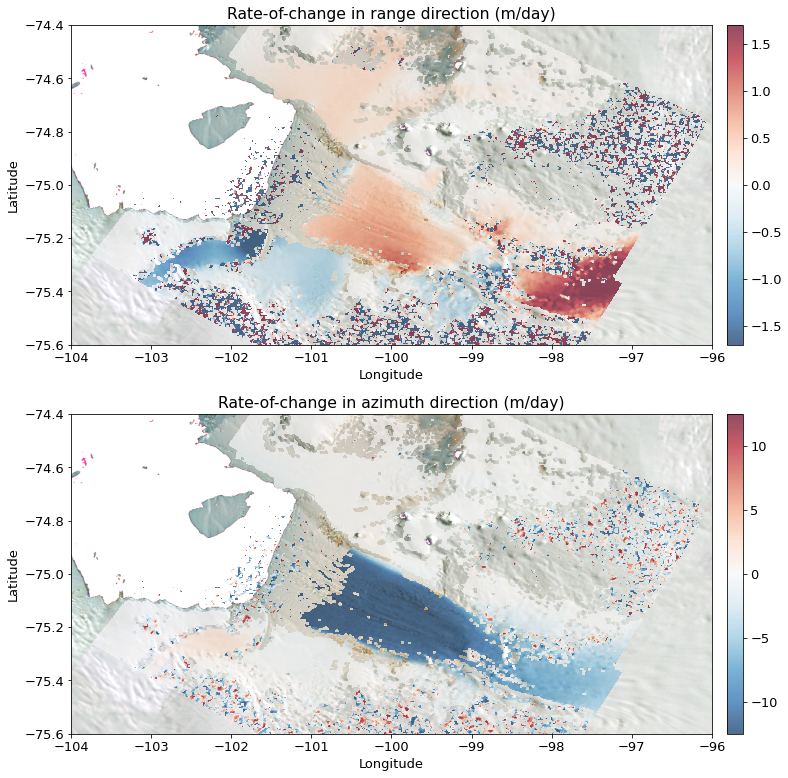

In [25]:
# Call helper routine to plot offsets on top of LIMA image. Low SNR regions have been masked out
plot_offsets('merged', parent_dir)

Let's now repeat the same process for the second date pair, `20200124_20200118`. The processing steps are identical, so we'll just copy and paste the shell commands from above.

In [6]:
os.chdir(os.path.join(parent_dir, '20200124_20200118'))

In [ ]:
# Run initialization steps: unpacking data, aux/orbit data, and verifying DEM
!topsApp.py --start=startup --end=verifyDEM

In [27]:
# Topo, co-registration
!topsApp.py --start=topo --end=geocode > coregister.log
# Run offsets, filter, and geocode
!topsApp.py --start=denseoffsets --end=geocodeoffsets > ampcor.log

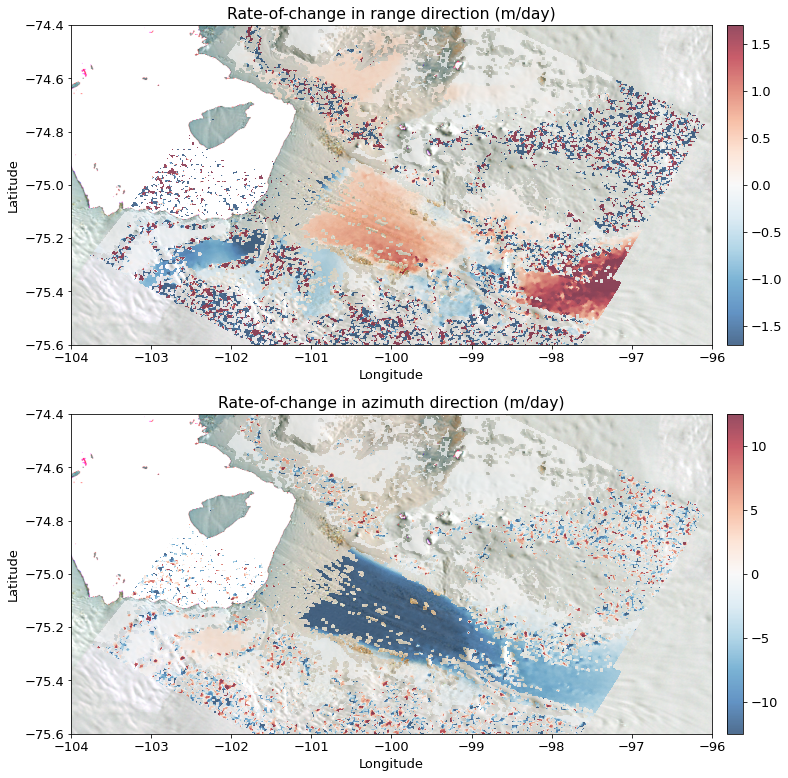

In [7]:
plot_offsets('merged', parent_dir)

Finally, let's run `topsApp.py` for the third date pair, `20200130_20200124`. Again, all of these processing steps would be made easier by running the TOPS stack processor in ISCE.

In [8]:
os.chdir(os.path.join(parent_dir, '20200130_20200124'))

In [ ]:
# Run initialization steps: unpacking data, aux/orbit data, and verifying DEM
!topsApp.py --start=startup --end=verifyDEM

In [ ]:
# Topo, co-registration
!topsApp.py --start=topo --end=geocode > coregister.log
# Run offsets, filter, and geocode
!topsApp.py --start=denseoffsets --end=geocodeoffsets > ampcor.log

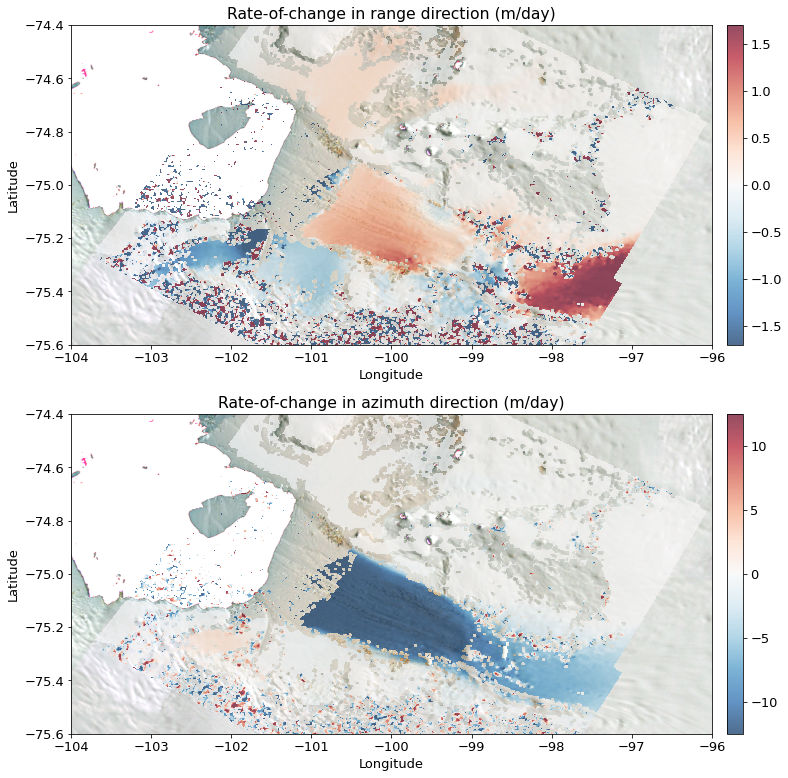

In [9]:
plot_offsets('merged', parent_dir)

## Simple stack post-processing to estimate mean velocity

Now that we have three sets of georegistered range and azimuth offset maps, let's create a rudimentary stack by resampling all maps to a common geographic grid. The stack will be a 3D array with shape `(Ny, Nx, Nt)` where `Nt` is the number of time epochs in the stack (3). Let's also plot the time series for a point in the middle of the ice shelf.

In [18]:
os.chdir(parent_dir)

Stack array shape: (432, 2878, 3)
Time series latitude: -75.12133569999999
Time series longitude: -100.11009075


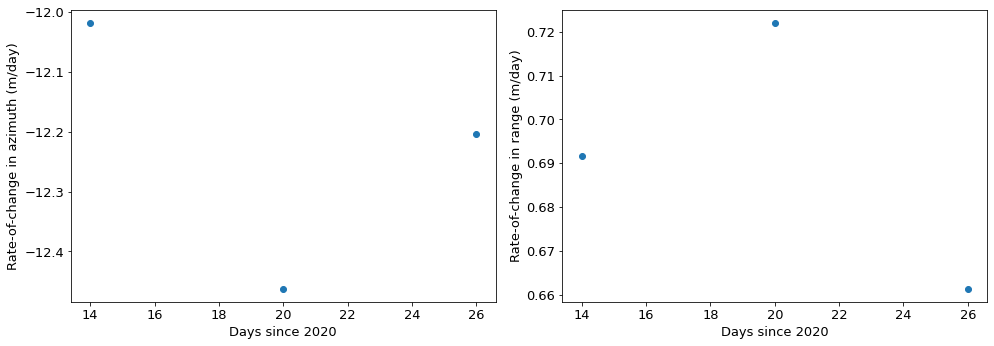

In [19]:
# Create stacks
astack, tdec, extent = create_stack(offset_band=1)
rstack, _, _ = create_stack(offset_band=2)
days = (tdec - 2020) * 365
print('Stack array shape:', rstack.shape)

# The geographic coordinates of the stack
lat = np.linspace(extent[3], extent[2], astack.shape[0])
lon = np.linspace(extent[0], extent[1], astack.shape[1])

# Coordinate of time series we wish to view
row = 260
col = 1400
lon_pix = lon[col]
lat_pix = lat[row]
print('Time series latitude:', lat_pix)
print('Time series longitude:', lon_pix)

# Plot example time series on the ice shelf
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5))
ax1.plot(days, astack[row, col, :], 'o')
ax2.plot(days, rstack[row, col, :], 'o')
ax1.set_xlabel('Days since 2020')
ax2.set_xlabel('Days since 2020')
ax1.set_ylabel('Rate-of-change in azimuth (m/day)')
ax2.set_ylabel('Rate-of-change in range (m/day)')
fig.set_tight_layout(True)

As we can see, there's not too much variation in the offsets in this short time window we have processed. Later, we will show a longer time series from a dataset also generated from dense offsets. For now, let's go ahead and create the simplest time series "model" we can: the mean rate-of-change in the range and azimuth directions. Computing the mean is equivalent to fitting a zeroth-order polynomial to the time series.

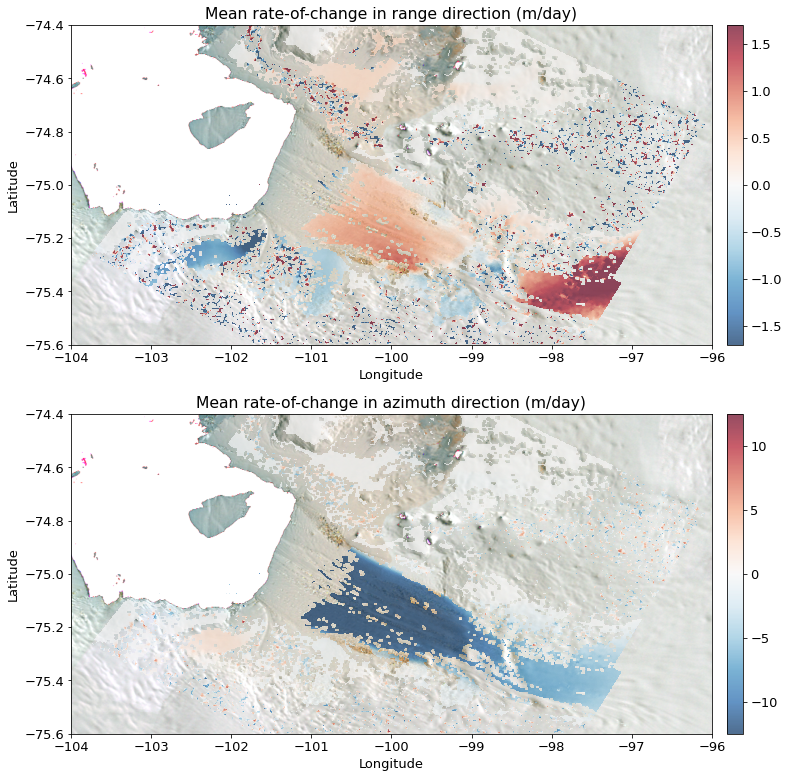

In [20]:
# Compute mean velocities in both directions (use np.mean to kick out any NaN values)
mean_r = np.mean(rstack, axis=2)
mean_a = np.mean(astack, axis=2)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 11))

# Load background LIMA image
lima, lima_extent = load_lima(parent_dir)

def imshow(ax, arr, extent=None, cmap='RdBu_r', clim=(-5, 5), cbar=True, **kwargs):
    im = ax.imshow(arr, cmap=cmap, clim=clim, extent=extent, **kwargs)
    if cbar:
        cb = plt.colorbar(im, ax=ax, pad=0.02)
        return im, cb
    else:
        return im

# Plot LIMA as background
imshow(ax1, lima, extent=lima_extent, cmap=None, cbar=False, clim=None)
imshow(ax2, lima, extent=lima_extent, cmap=None, cbar=False, clim=None)

# Plot offsets
imshow(ax1, mean_r, extent=extent, clim=(-1.7, 1.7), alpha=0.7, aspect='auto')
imshow(ax2, mean_a, extent=extent, clim=(-12.5, 12.5), alpha=0.7, aspect='auto')

# Decoration
ax1.set_title('Mean rate-of-change in range direction (m/day)')
ax2.set_title('Mean rate-of-change in azimuth direction (m/day)')
for ax in (ax1, ax2):
    ax.set_xlim(-104, -96)
    ax.set_ylim(-75.6, -74.4)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
fig.set_tight_layout(True)

## Example velocity time series over PIG from 2015 - 2021

Courtesy of Ian Joughin at the University of Washington (NASA MEaSUREs project), we have obtained a stack of horizontal velocities over PIG from 2015-2021. These maps were generated using similar dense offset techniques applied to a combination of Sentinel-1 A/B and TerraSAR-X SLCs in order to form montly velocity mosaics. Let's look at a longer time series (horizontal velocity magnitude) for the same location on the ice shelf we viewed in the previous plot. Additionally, we will perform a more sophisticated time series fit that simultaneously models short- and long-term variations in the time series (Riel, B., Minchew, B. and Joughin, I., 2021, *The Cryosphere*).

<img src="support_files/pig_tseries.png" width=570 height=400 align="left"/>

From the above time series, we can see that the three offset maps we generated occurred in the middle of a long-term speedup event at PIG, which is a consequence of successive large-scale calving events at the ice shelf. As a demonstration of the utility of time series decomposition techniques on a larger scale, let's look at an animation of reconstructed speed changes at PIG (the top plot in the figure above, applied to every pixel), draped over time-varying Sentinel-1 imagery (animation below is in polar stereographic projection, which is rotated roughly 90 degrees from our previous maps). We can clearly see the association between calving events and increases in speed over the ice shelf and near-grounding line ice.

<video controls src="support_files/pig_norm_velocities_sentinel.mp4" width=800 height=400 align="left"/>

## Important additional topics

There are a few post-processing steps not covered here that need to be performed prior to scientific analysis:

1. Range and azimuth offsets need to be transformed to geographic coordinates, e.g. East-North-Up. While the azimuth offsets are only sensitive to horizontal displacements, the range offsets are also sensitive to vertical displacements due to the incidence angle. In glaciology, we often assume surface parallel flow in order to solve for horizontal velocity components from the range and azimuth offsets. If one has offsets from a different viewing geometry (e.g., descending vs. ascending pass), then the ENU components can be solved for directly.

2. Quantify uncertainties in the offsets using the covariance files, `dense_offsets_cov.bil.geo`. Propagate these uncertainties to rotated velocities in geographic coordinates.

3. Explore offset processing parameters, including window size, search window size, and filter window size. It's possible that a different set of parameter values will result in higher-quality offset maps.